<a href="https://colab.research.google.com/github/akatari2024-debug/Augmentation-pytorch3d-assignment/blob/main/Augmented_reality_with_PyTorch3D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# In a Colab cell, run this to install PyTorch3D and other dependencies
import os
import sys
import torch
need_pytorch3d=False
try:
    import pytorch3d
except ModuleNotFoundError:
    need_pytorch3d=True
if need_pytorch3d:
    if torch.__version__.startswith("2.3.") and sys.platform.startswith("linux"):
        # We try to install PyTorch3D from a pre-compiled wheel.
        pyt_version_str=torch.__version__.split("+")[0].replace(".", "")
        version_str="".join([
            f"py3{sys.version_info.minor}_cu",
            torch.version.cuda.replace(".",""),
            f"_pyt{pyt_version_str}"
        ])
        !pip install fvcore iopath
        !pip install --no-index --no-cache-dir pytorch3d -f https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/{version_str}/download.html
    else:
        # We try to install PyTorch3D from source, this may take a while.
        !pip install 'git+https://github.com/facebookresearch/pytorch3d.git@stable'

!pip install opencv-python matplotlib

# General imports
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pytorch3d.io import load_obj
from pytorch3d.structures import Meshes
from pytorch3d.renderer import (
    look_at_view_transform,
    FoVPerspectiveCameras,
    PointLights,
    DirectionalLights,
    Materials,
    RasterizationSettings,
    MeshRenderer,
    MeshRasterizer,
    SoftPhongShader,
    TexturesUV,
    TexturesVertex
)

  Cloning https://github.com/facebookresearch/pytorch3d.git (to revision stable) to /tmp/pip-req-build-5w1drd2z
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/pytorch3d.git /tmp/pip-req-build-5w1drd2z
  Running command git checkout -q 75ebeeaea0908c5527e7b1e305fbc7681382db47
  Resolved https://github.com/facebookresearch/pytorch3d.git to commit 75ebeeaea0908c5527e7b1e305fbc7681382db47
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 3.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pytorch3d: filename=pytorch3d-0.7.8-cp312-cp312-linux_x86_64.whl size=61842304 sha256=7fb4345fabd5018e6cd9bc759cbe0dd87f4c67e5a5f43afe569b32f4b1e782cf
  Stored in directory: /tmp/pip-ephem-wheel-cache-a4nb3f6k/wheels/e9/ec/88/13a99edfc9de29485b221df3503c3bca62e23abac9f2b3a974
  Created wheel for iopath: filename=iopath-0.1.10-py3-none-any.whl size=31527 sha256=e7f10ccb82fa36b3952eef7

/bin/bash: line 1: wget/content/IMG_5108.DNG: No such file or directory
Image size: width=4816, height=4621


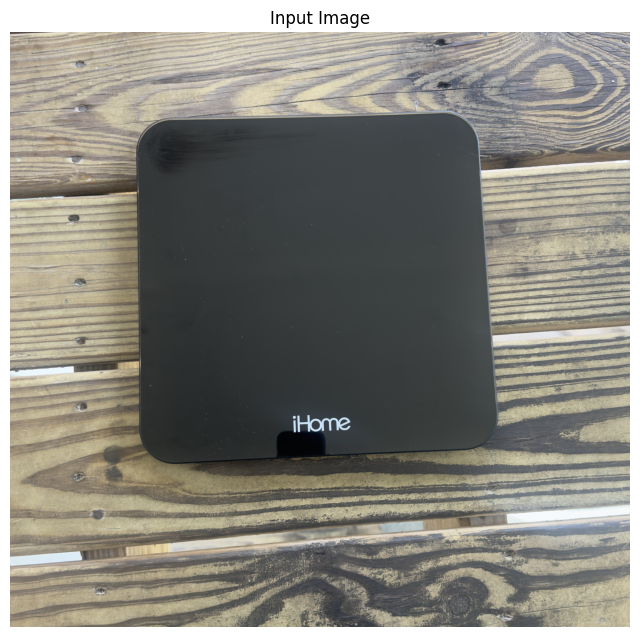

In [3]:
# Download a sample image to make the notebook reproducible
!wget/content/IMG_5108.DNG
# Load the image using OpenCV
image_path = '/content/IMG_5108.DNG'
image_bgr = cv2.imread(image_path)
if image_bgr is None:
    raise FileNotFoundError(f"Image not found at {image_path}")

image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
height, width, _ = image_rgb.shape
print(f"Image size: width={width}, height={height}")

plt.figure(figsize=(8, 8))
plt.imshow(image_rgb)
plt.title("Input Image")
plt.axis('off')
plt.show()

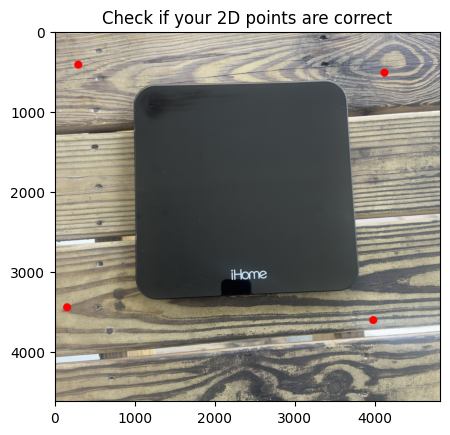

In [10]:
# 1. Enter the real-world dimensions of your object (e.g., in cm).
object_width_cm = 15.0 # UPDATE THIS
object_height_cm = 15.0 # UPDATE THIS

# 2. Enter the pixel coordinates you found for the four corners.
# Make sure the order is correct!
image_points_2d = np.array([
   [290, 420],   # Top-left
    [4110, 520],  # Top-right
    [3970, 3610], # Bottom-right
    [150, 3450]   # Bottom-left
], dtype=np.float32)


# Visualize the points on your image to check alignment.
# PRO-TIP: I've increased the circle radius from 10 to 50 to make it more visible on your large image.
vis_image = image_rgb.copy()
for i, p in enumerate(image_points_2d):
    cv2.circle(vis_image, tuple(p.astype(int)), 50, (255, 0, 0), -1)
plt.imshow(vis_image)
plt.title("Check if your 2D points are correct")
plt.show()

In [11]:
# 1. Enter the real-world dimensions of your object (e.g., in cm).
object_width_cm = 15.0
object_height_cm = 20.0

# Define the 3D points
world_points_3d = np.array([
    [0, 0, 0],
    #... more points
], dtype=np.float32)

# Define the 2D points
image_points_2d = np.array([
    [100, 150],
    #... more points
], dtype=np.float32)

In [12]:
# 🔢 Ensure there are four [x, y, z] points here
world_points_3d = np.array([
    [0, 0, 0],                              # Point 1: Top-left
    [object_width_cm, 0, 0],                # Point 2: Top-right
    [object_width_cm, object_height_cm, 0], # Point 3: Bottom-right
    [0, object_height_cm, 0]                # Point 4: Bottom-left
], dtype=np.float32)

# 🔢 Ensure there are four [x, y] points here, in the same order
image_points_2d = np.array([
    [290, 420],   # Point 1
    [4110, 520],  # Point 2
    [3970, 3610], # Point 3
    [150, 3450]   # Point 4
], dtype=np.float32)

In [13]:
# You might need to download the teapot.obj file first
!wget https://raw.githubusercontent.com/facebookresearch/pytorch3d/main/docs/tutorials/data/teapot.obj -P data/
# Define the device for PyTorch (GPU if available, otherwise CPU)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Now you can load the mesh
verts, faces, aux = load_obj("data/teapot.obj")
faces_idx = faces.verts_idx.to(device)
verts = verts.to(device)

# Load the teapot mesh from the .obj file
verts, faces, aux = load_obj("data/teapot.obj")
faces_idx = faces.verts_idx.to(device)
verts = verts.to(device)

# --- Position the Teapot ---
# We want the teapot to sit in the middle of our real-world object.
# We'll move its vertices using the dimensions you specified earlier.
center_x = object_width_cm / 2.0
center_y = object_height_cm / 2.0

# Scale the teapot and move it to the object's center
# The '-2.0' in Z raises it slightly so it sits 'on top' of the surface
center_translation = torch.tensor([center_x, center_y, -2.0], device=device)
verts = (verts * 2.0) + center_translation

# Assign a color to the teapot using textures
# We'll make it a nice purple color
color = torch.tensor([0.7, 0.2, 0.9], device=device) # [R, G, B]
verts_rgb = torch.ones_like(verts)[None] * color # (1, V, 3)
textures = TexturesVertex(verts_features=verts_rgb)

# Create a PyTorch3D Meshes object
mesh = Meshes(
    verts=[verts],
    faces=[faces_idx],
    textures=textures
)

print("✅ Teapot mesh loaded and positioned!")

--2025-10-02 05:05:39--  https://raw.githubusercontent.com/facebookresearch/pytorch3d/main/docs/tutorials/data/teapot.obj
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 152595 (149K) [text/plain]
Saving to: ‘data/teapot.obj’

teapot.obj          100%[===================>] 149.02K  --.-KB/s    in 0.01s   

2025-10-02 05:05:39 (11.1 MB/s) - ‘data/teapot.obj’ saved [152595/152595]



/usr/local/lib/python3.12/dist-packages/pytorch3d/io/obj_io.py:546: UserWarning: No mtl file provided
  warnings.warn("No mtl file provided")


✅ Teapot mesh loaded and positioned!


In [16]:
# --- Part 1: Define Camera Intrinsics (Missing Step) ---
# Assume camera intrinsics based on the image dimensions
focal_length = width
center = (width/2, height/2)
camera_matrix = np.array([
    [focal_length, 0, center[0]],
    [0, focal_length, center[1]],
    [0, 0, 1]
], dtype=np.float32)
dist_coeffs = np.zeros((4,1)) # Assuming no lens distortion
print("✅ Camera Matrix Created!")


# --- Part 2: Calculate Camera Pose ---
# Use solvePnP to find the rotation (rvec) and translation (tvec)
success, rvec, tvec = cv2.solvePnP(world_points_3d, image_points_2d, camera_matrix, dist_coeffs)
if not success:
    raise Exception("Camera pose estimation failed. Check your 2D/3D points.")

# Convert rotation vector to a full 3x3 rotation matrix and get T_cv
R_cv, _ = cv2.Rodrigues(rvec)
T_cv = tvec
print("✅ Camera Pose Estimated Successfully!")


# --- Part 3: Convert Pose for PyTorch3D ---
# The conversion matrix to flip the X and Y axes
M = np.array([
    [-1, 0, 0],
    [0, -1, 0],
    [0, 0, 1]
], dtype=np.float32)

# Apply the conversion
R_p3d = np.dot(M, R_cv)
T_p3d = np.dot(M, T_cv).reshape(3)

# Convert the NumPy arrays to PyTorch tensors
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
R = torch.from_numpy(R_p3d).unsqueeze(0).to(device)
T = torch.from_numpy(T_p3d).unsqueeze(0).to(device)
print("✅ Pose converted successfully for PyTorch3D!")

✅ Camera Matrix Created!
✅ Camera Pose Estimated Successfully!
✅ Pose converted successfully for PyTorch3D!


✅ PyTorch3D Scene Ready
🖼️ Final Image Rendered!


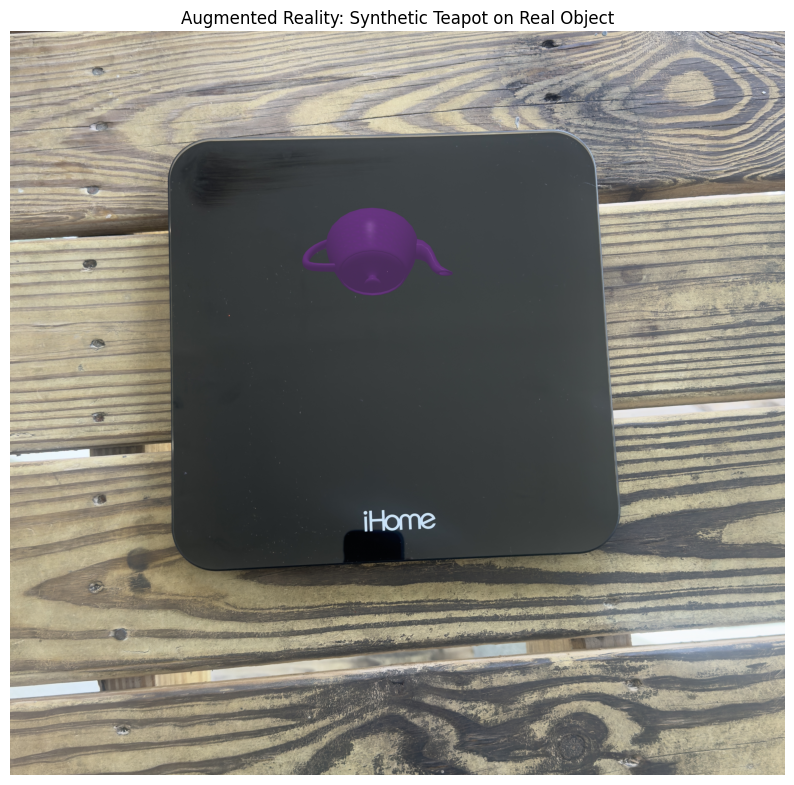

In [18]:
# --- Part 1: Setup PyTorch3D Scene (This was the missing step) ---
# Create a camera and renderer with the calculated pose
cameras = FoVPerspectiveCameras(device=device, R=R, T=T, fov=2 * np.arctan(height / (2 * focal_length)) * 180 / np.pi)
raster_settings = RasterizationSettings(image_size=(height, width), blur_radius=0.0, faces_per_pixel=1)
lights = PointLights(device=device, location=[[0.0, 0.0, -100.0]])
renderer = MeshRenderer(
    rasterizer=MeshRasterizer(cameras=cameras, raster_settings=raster_settings),
    shader=SoftPhongShader(device=device, cameras=cameras, lights=lights)
)
print("✅ PyTorch3D Scene Ready")


# --- Part 2: Render and Composite the Final Image (Your original code) ---
# Render the teapot
rendered_images = renderer(mesh)

# Extract the RGB image and the alpha channel (mask)
rendered_rgb = rendered_images[0, ..., :3].cpu().numpy()
alpha_mask = rendered_images[0, ..., 3].cpu().numpy()[..., None] # Use alpha for blending

# Combine the real image with the rendered object
original_image_float = image_rgb / 255.0
final_image = original_image_float * (1 - alpha_mask) + rendered_rgb * alpha_mask

# Display the result
print("🖼️ Final Image Rendered!")
plt.figure(figsize=(10, 10))
plt.imshow(final_image)
plt.title("Augmented Reality: Synthetic Teapot on Real Object")
plt.axis('off')
plt.show()